# **Sesión 1: Redes neuronales totalmente conectadas**

In [ ]:
# Dependencias que vamos a emplear durante la sesión

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

from itertools import cycle

import numpy as np

import pandas as pd

# Implementación de una capa totalmente conectada

En la primera parte de la práctica vamos a implementar una red neuronal totalmente conectada con una capa de entrada y otra de salida a bajo nivel empleando Tensorflow. Luego veremos como, con la misma librería podemos realizar esta implementación a más alto nivel.

Recordatorio:

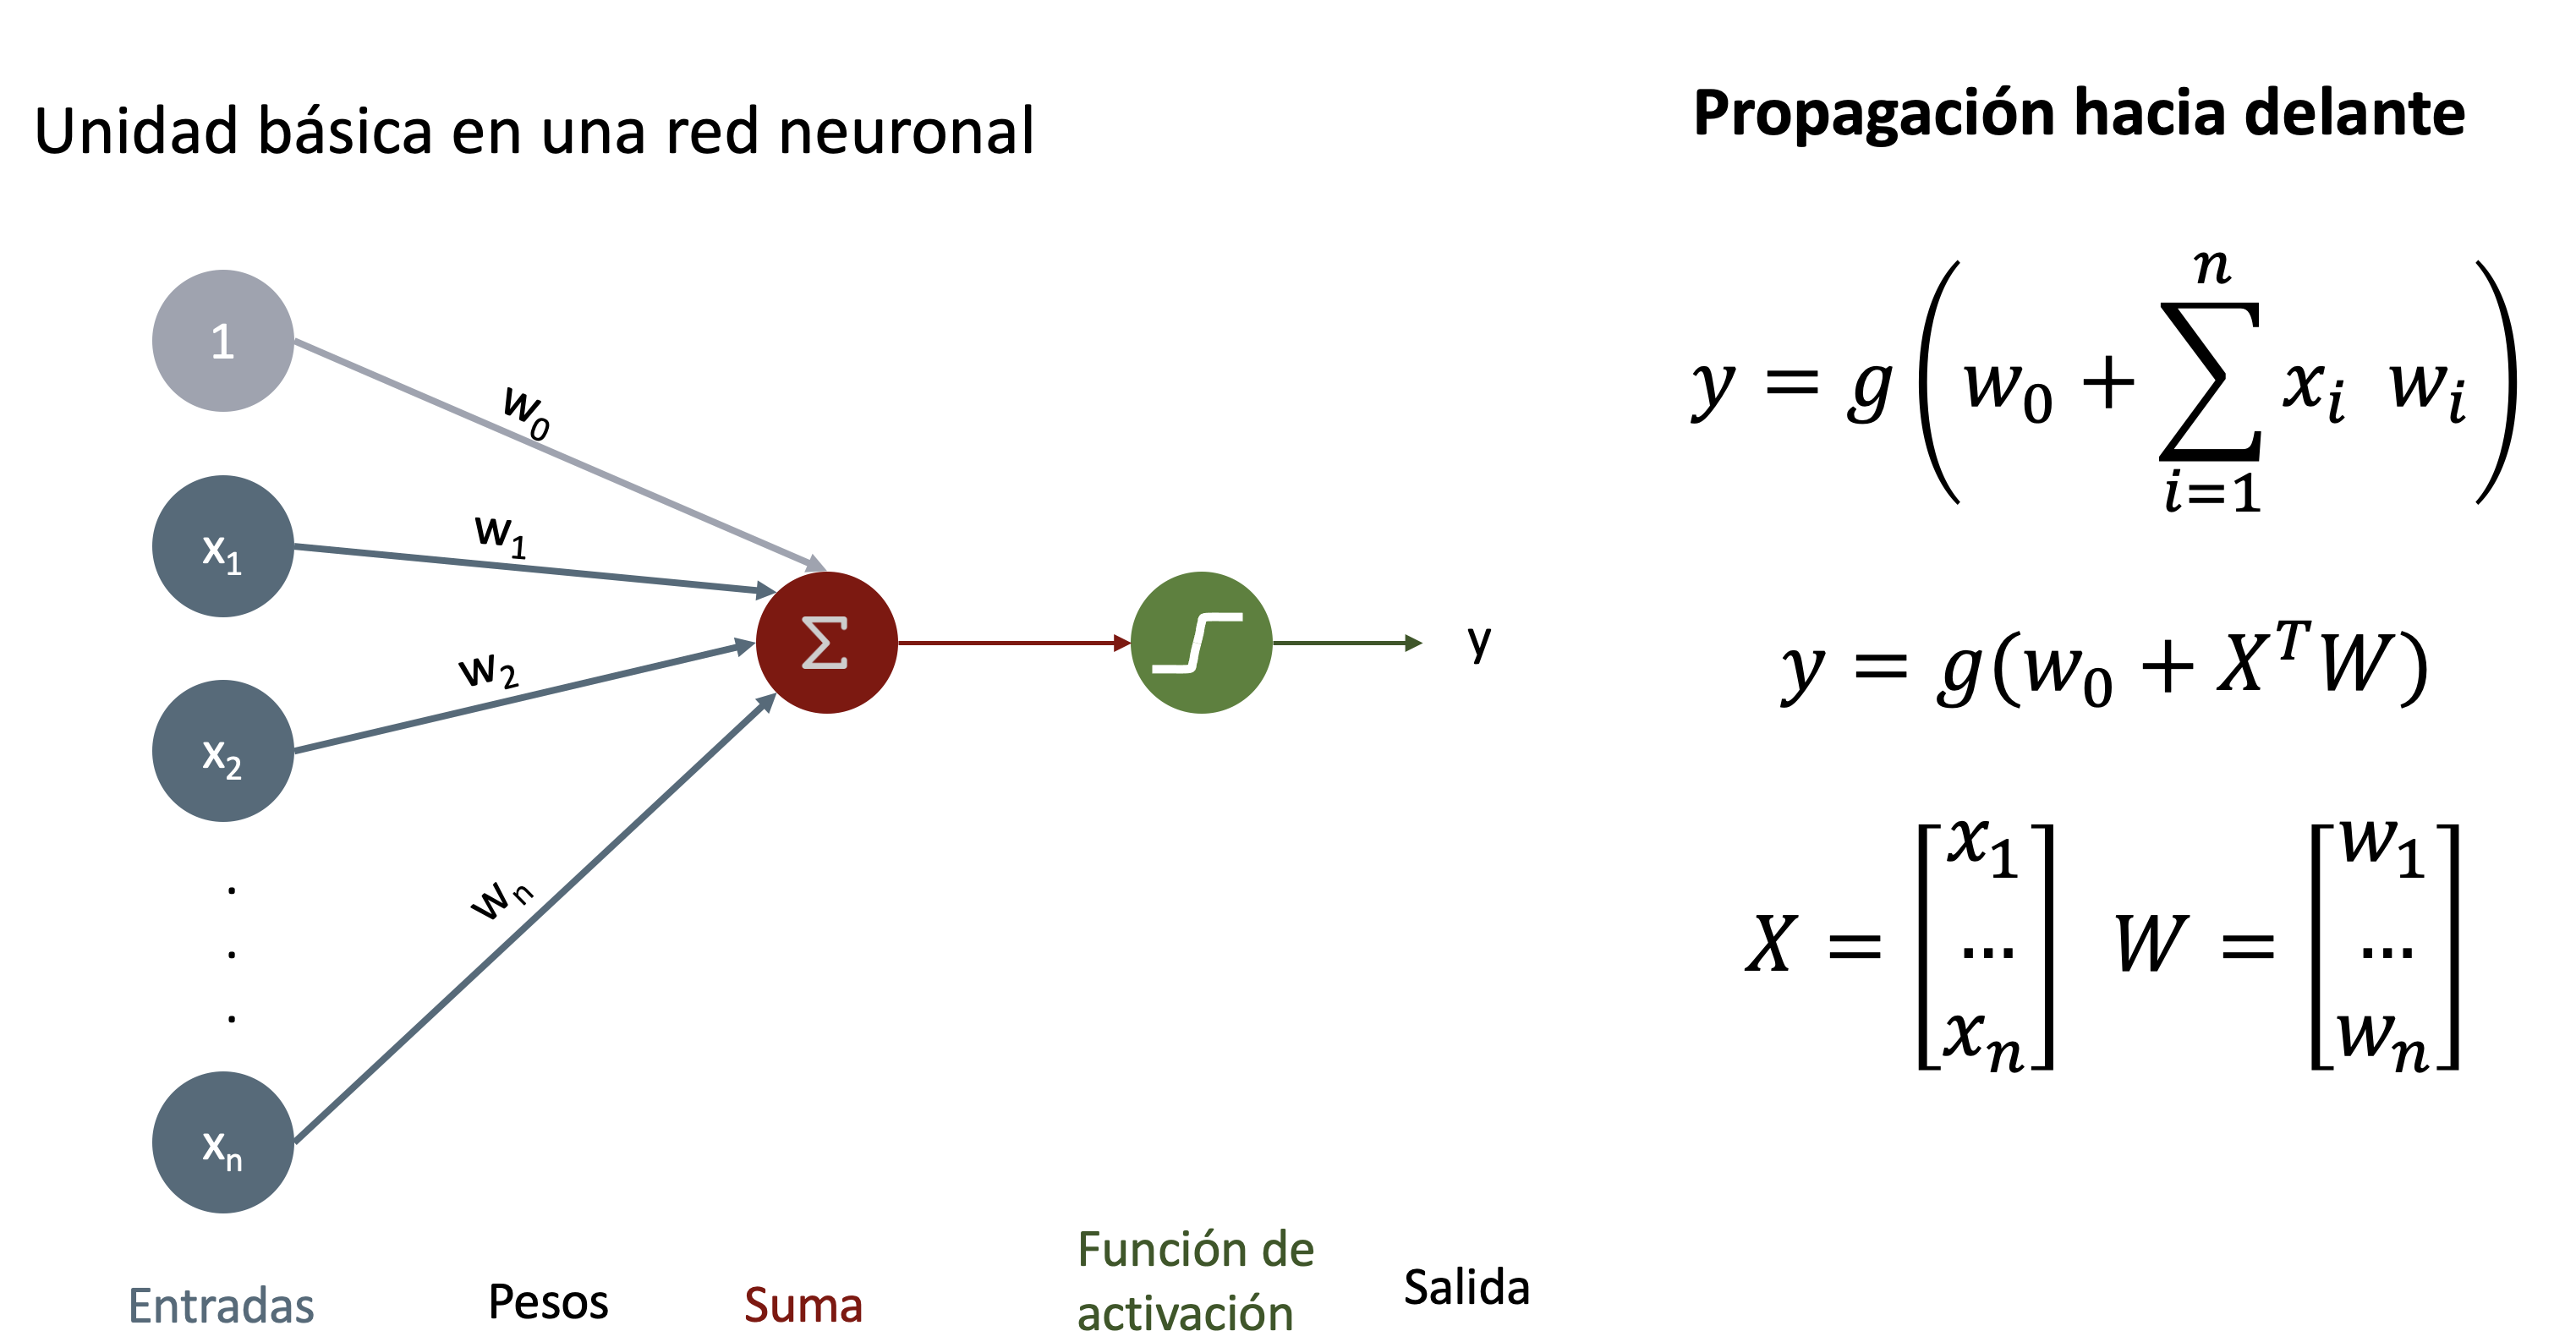

Para la implementación vamos a emplear la clase base "Layer" de Keras (https://keras.io/api/layers/base_layer/). Una "layer" es un objecto que toma como entrada uno o más tensores y que genera uno o mas tensores como salida. Para su implementación se debe definir el cálculo que se hace en esta capa a través del método "call()" y el estado de la capa (pesos, variables), que se puede definir tanto en el contructor (método "__init__()") o en el método "build()"

En primer lugar, vamos a implementar una capa que toma 2 entrada y genera 3 salidas:

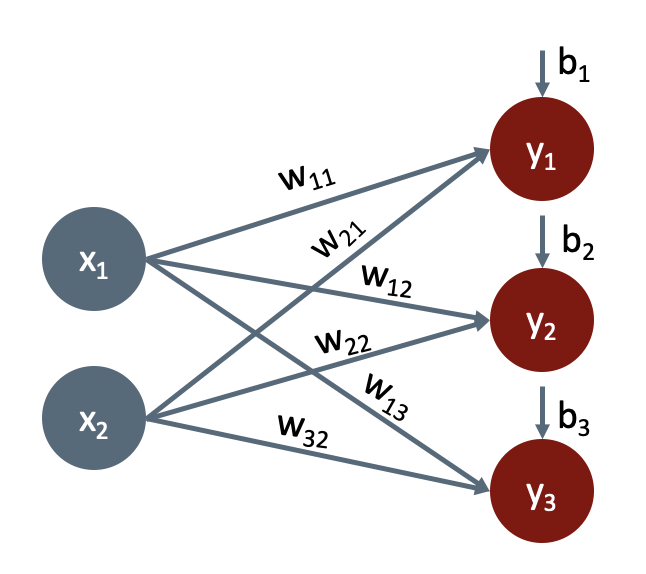

In [ ]:
class OurDenseLayer(tf.keras.layers.Layer):
  def __init__(self, n_output_nodes):
    super(OurDenseLayer, self).__init__()
    # Inicializamos el número de salidas (n_output_nodes)
    self.n_output_nodes = n_output_nodes

  def build(self, input_shape):
    # input_shape: Tamaño de la entrada
    # Número de entradas
    d = int(input_shape[-1])
    # Definimos e inicializamos los parámetros: una matriz de pesos (W) y el bias (b)
    # La inicializacion de los parámetros se realiza de forma aleatoria
    self.W = self.add_weight("weight", shape=[d, self.n_output_nodes]) 
    self.b = self.add_weight("bias", shape=[1, self.n_output_nodes])

  def call(self, x):
    z = tf.matmul(x, self.W) + self.b
    y = tf.sigmoid(z)
    return y

# Dado que los parámetros se inicializan aleatoriamente, fijamos la semilla de la aletoriedad para obtener los mismos resultados
tf.random.set_seed(1)
# 1. Inicializamos la capa que hemos construído con 3 nodos de salida
layer = OurDenseLayer(3)
# 2. Construímos la capa con una capa de entrada de tamañan (1,2) - (1 fila, 2 columnas)
layer.build((1,2))
# 3. Extraemos la salida, para ello primero creamos un tensor que contiene las 2 entradas
x_input = tf.constant([[3.,4.]], shape=(1,2))
y = layer.call(x_input)

print('Entrada: ', x_input.numpy())
print('Pesos y bias: ', layer.weights)
print('Salida: ', y.numpy())

Entrada:  [[3. 4.]]
Pesos y bias:  [<tf.Variable 'weight:0' shape=(2, 3) dtype=float32, numpy=
array([[-0.73366153,  0.8796015 ,  0.28695   ],
       [-0.14340228, -0.4558388 ,  0.3122064 ]], dtype=float32)>, <tf.Variable 'bias:0' shape=(1, 3) dtype=float32, numpy=array([[ 0.02475715, -0.13831842, -0.2240473 ]], dtype=float32)>]
Salida:  [[0.06009588 0.663098   0.8682563 ]]


¿Cómo se ha calculado la salida?

y_1 = sigmoid(3 * (-0.73366153) + 4 * (-0.14340228) + 0.02475715)

y_2 = sigmoid(3 * (0.8796015) + 4 * (-0.4558388) + (-0.13831842))

y_3 = sigmoid(3 * (0.28695) + 4 * (0.3122064) + (-0.2240473))

En segundo lugar vamos a aprovechar la API de Keras para implementar la misma capa que anteriormente a un nivel superior de abstracción

In [ ]:
# Número de salidas
n_output_nodes = 3

# Inicializamos el modelo
model = Sequential()

# Añadimos una capa totalmente conectada (Dense) al modelo
dense_layer = Dense(n_output_nodes, activation='sigmoid') 
model.add(dense_layer)

# Vemos la salida del modelo ante una entrada dada
x_input = tf.constant([[3.,4.]], shape=(1,2))
model_output = model(x_input).numpy()

print('Entrada: ', x_input.numpy())
print('Pesos y bias: ', model.weights)
print('Salida: ', model_output)

Entrada:  [[3. 4.]]
Pesos y bias:  [<tf.Variable 'dense/kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[ 0.72141063,  0.29407883,  0.0322665 ],
       [-0.23862988,  0.1772492 , -0.9892268 ]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]
Salida:  [[0.77024806 0.83078957 0.02063113]]


In [ ]:
# Vemos el modelo que hemos creado
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (1, 3)                    9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


# Descenso de gradiente estocástico

Vamos a implementar el proceso de ajuste de los pesos empleando el algoritmo de desenso de gradiente estocástico para la minimización de una función de coste.

En este ejemplo vamos a emplear la función de coste x-x^2, con una tasa de aprendizaje de 1e-2 y un valor objetivo de 4.


Recuerdo:

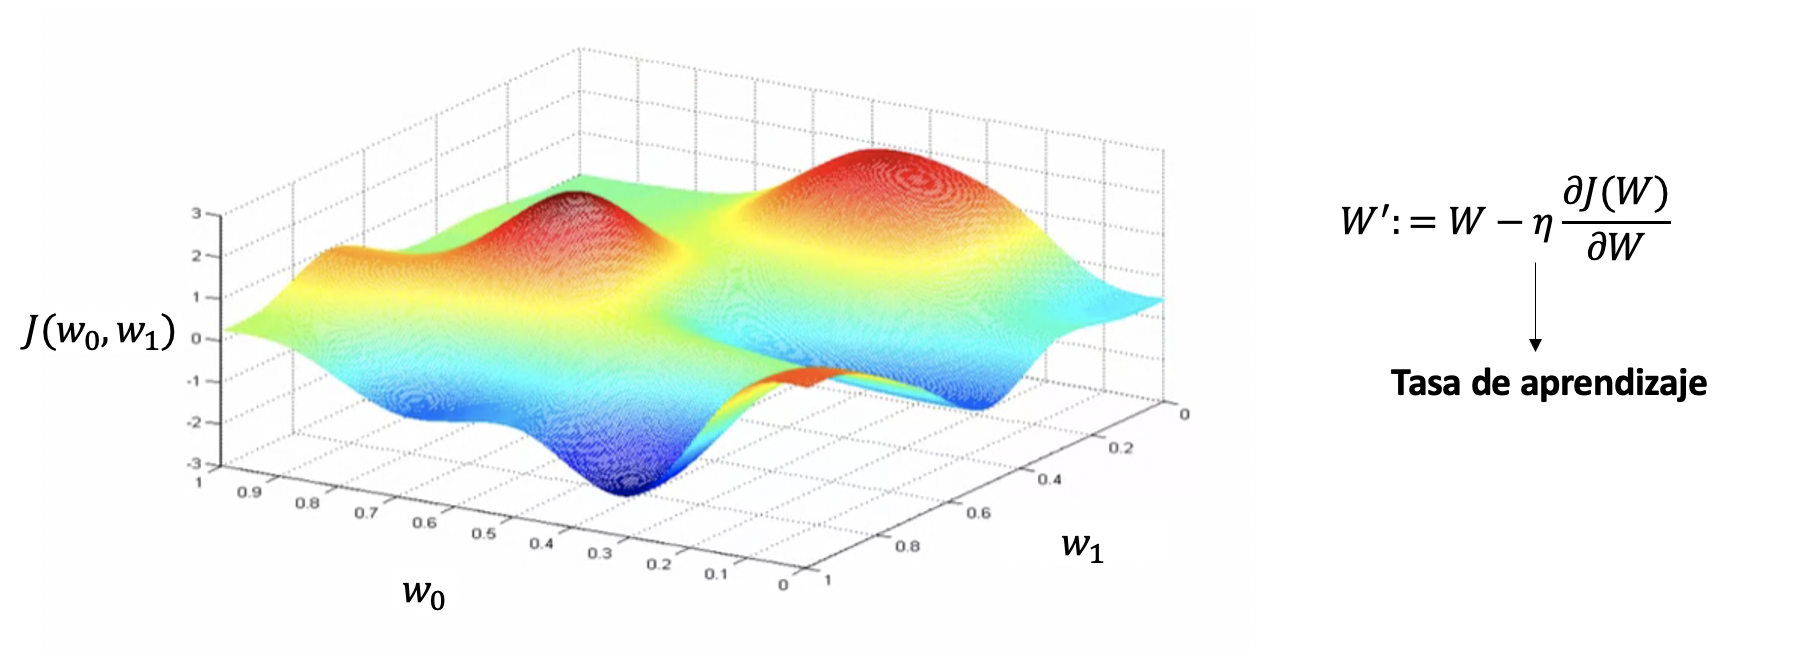


Valor inicial x=[[-0.45701224]]


Text(0, 0.5, 'Valor x')

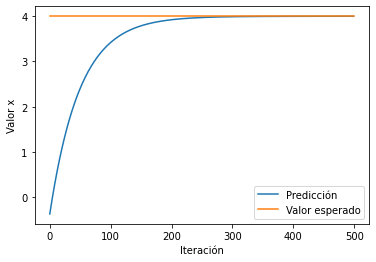

In [ ]:
# Inicializamos el valor de la salida de manera aleatoria
x = tf.Variable([tf.random.normal([1])])
print("Valor inicial x={}".format(x.numpy()))

learning_rate = 1e-2 # Tasa de aprendizaje
history = []
x_f = 4 # Valor objetivo

# Vamos a computar el descenso de gradiente estocástico durante una serie de iteraciones,
# calculamos las pérdidas, calculamos la derivada de las pérdidas con respecto a x,
# y actualizamos su valor

for i in range(500):
  with tf.GradientTape() as tape:
    # Función de pérdidas
    loss = (x - x_f)**2 

  # Calculamos la derivadas de las pérdidas con respecto a x (gradiente)
  grad = tape.gradient(loss, x)
  # Actualizamos el valor de x
  new_x = x - learning_rate*grad 
  x.assign(new_x)
  history.append(x.numpy()[0])

# Visualizamos los resultados
plt.plot(history)
plt.plot([0, 500],[x_f,x_f])
plt.legend(('Predicción', 'Valor esperado'))
plt.xlabel('Iteración')
plt.ylabel('Valor x')

# Redes neuronales para la resolución de problemas de regresión y clasificación

Vamos a emplear la base de datos de precios de casas de Boston (https://www.kaggle.com/c/boston-housing) en el que, dado una base de datos de 506 casas con 13 características asociadas a cada una de ellas, se pretende predecir el precio de la misma.

Para comprender la diferencia entre la resolución de problemas de regresión y clasificación vamos a abordar el problema de dos formas diferntes:
- Regresión: Predicción del precio de la casa
- Clasificación: Predicción si el precio de la casa va a ser ALTO, MEDIO o BAJO.

Para el entrenamiento, ajuste y testeo del modelo diseñado vamos a emplear los siguientes conjuntos de datos:

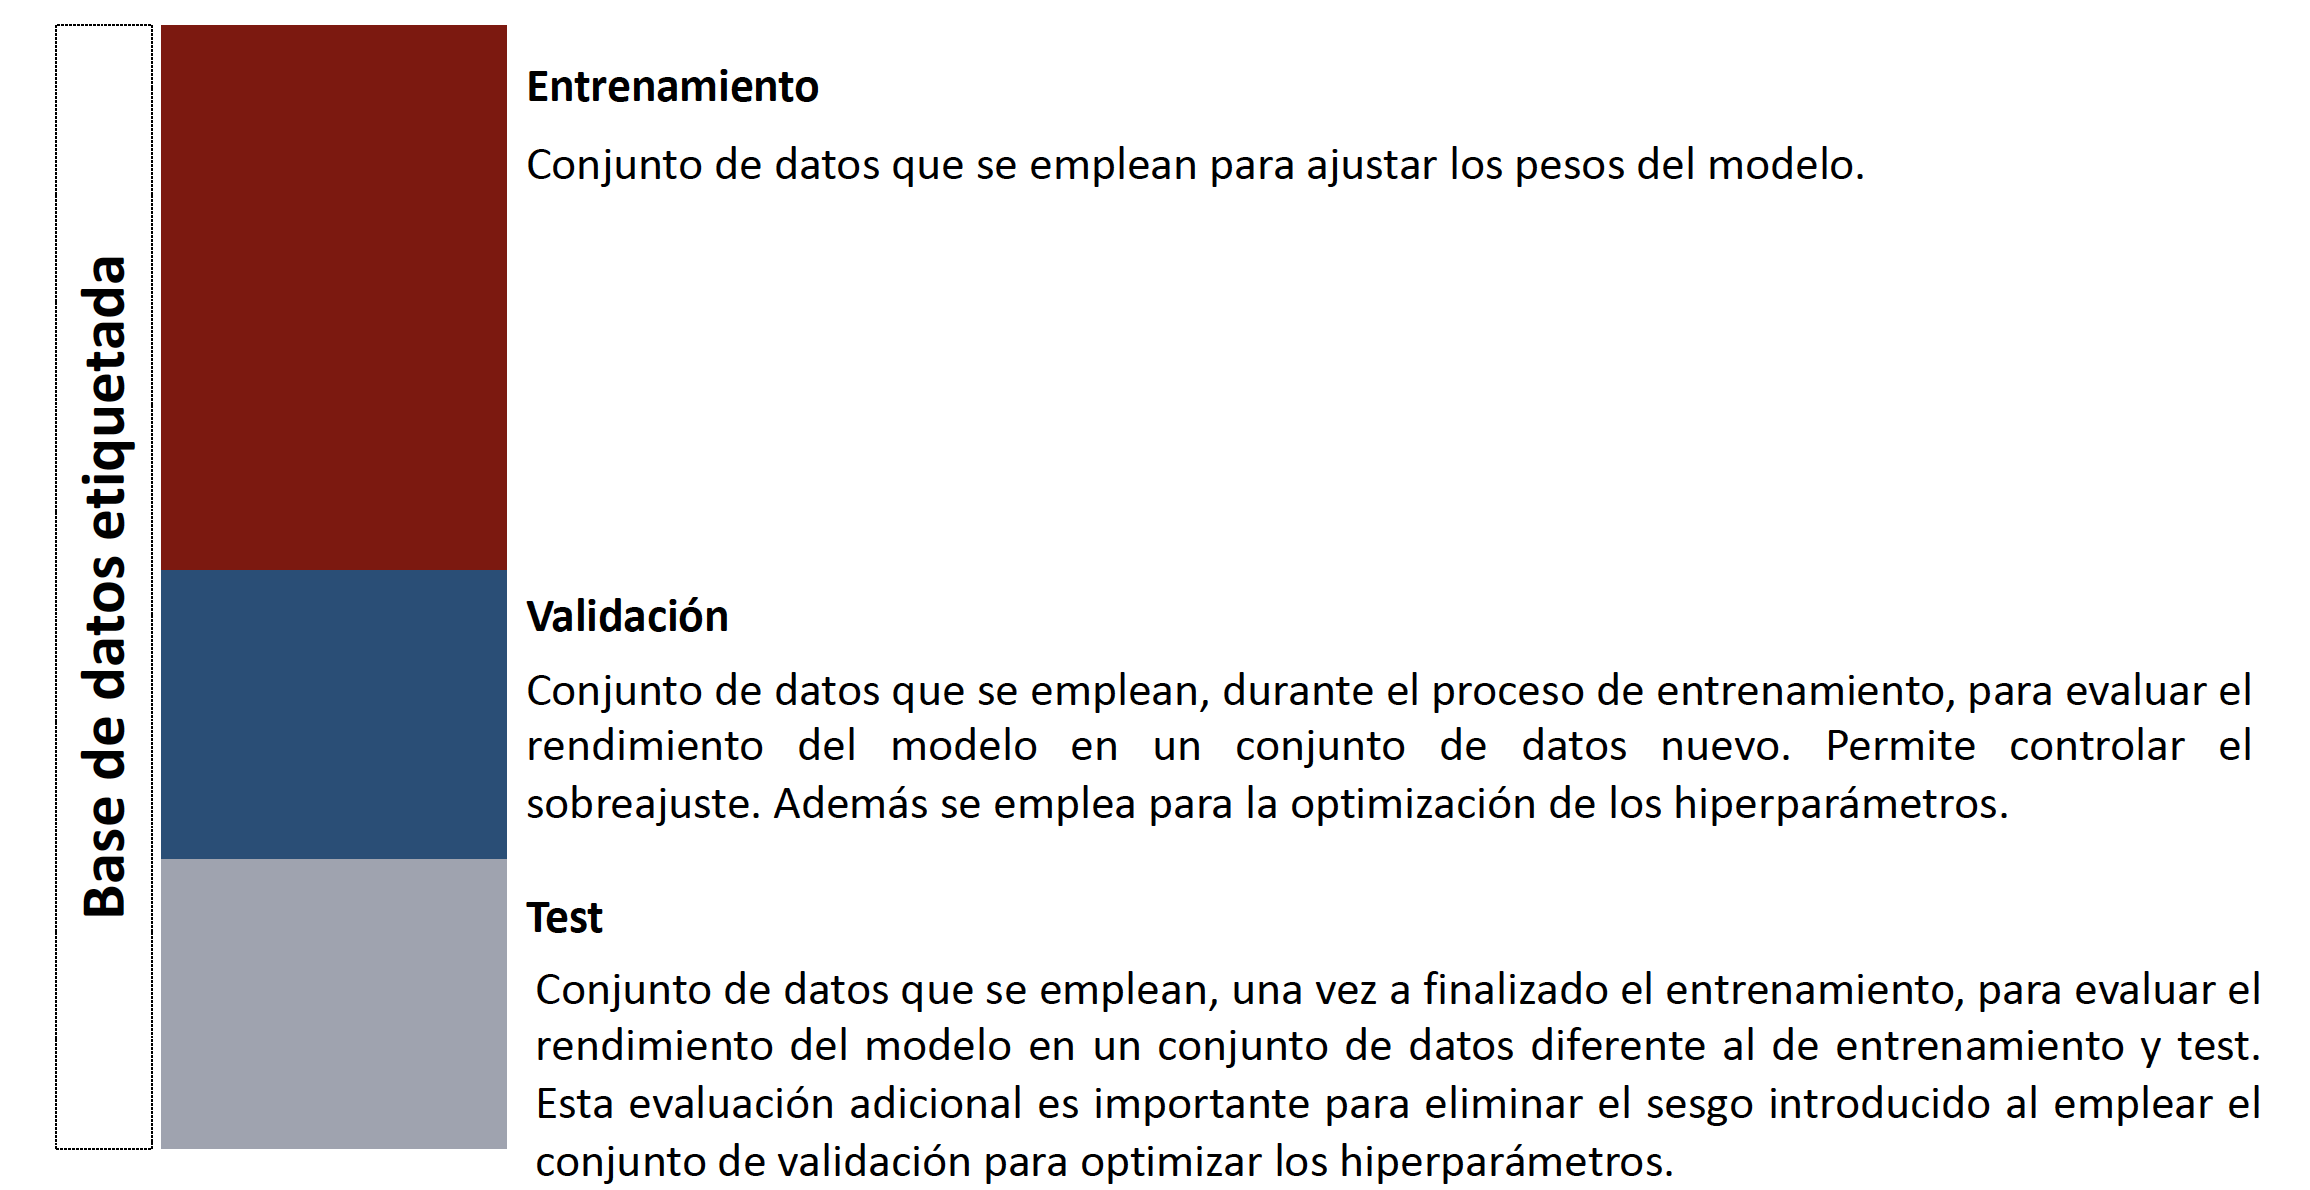

**Paso 1: Cargado y preparación de los datos**

Vamos a descarcar la base de datos de la [API de Keras](https://keras.io/api/datasets/). En esta podemos encontrar unos pocos datasets para entrenar nuestros modelos. 
Podemos encontrar más datasets en la [API de tensorflow](https://github.com/tensorflow/datasets).

In [ ]:
(X_train_val, y_train_val), (X_test, y_test) = keras.datasets.boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [ ]:
print('Entrada entrenamiento/validación: ', X_train_val.shape)
print('Salida entrenamiento/validación: ', y_train_val.shape)
print('Entrada test: ', X_test.shape)
print('Salida test: ', y_test.shape)

Entrada entrenamiento/validación:  (404, 13)
Salida entrenamiento/validación:  (404,)
Entrada test:  (102, 13)
Salida test:  (102,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

In [ ]:
print('Entrada entrenamiento: ', X_train.shape)
print('Salida entrenamiento: ', y_train.shape)
print('Entrada validación: ', X_val.shape)
print('Salida validación: ', y_val.shape)

Entrada entrenamiento:  (323, 13)
Salida entrenamiento:  (323,)
Entrada validación:  (81, 13)
Salida validación:  (81,)


Text(0.5, 1.0, 'Test. Min: 5.6, Max: 50.0, Media: 23.07843137254902')

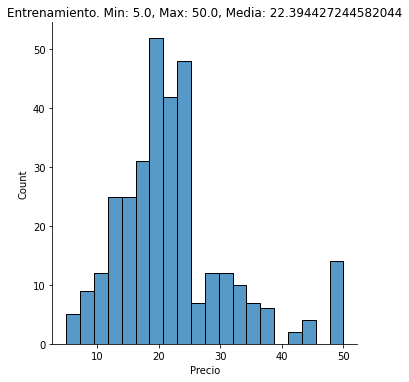

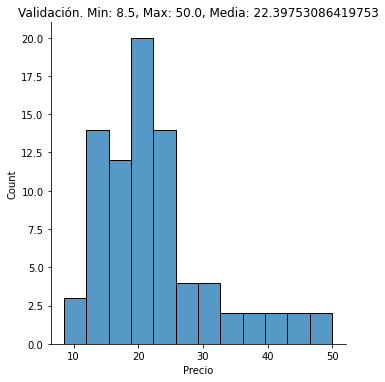

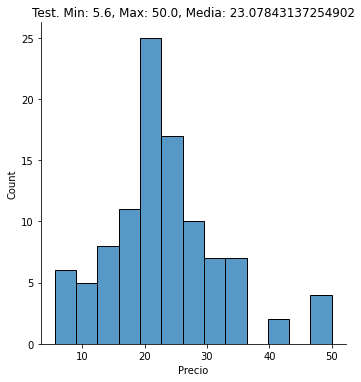

In [ ]:
# Visualizamos la salida en cada uno de los grupos para hacernos una idea de las distribuciones

sns.displot(y_train)
plt.xlabel('Precio')
plt.title(f'Entrenamiento. Min: {y_train.min()}, Max: {y_train.max()}, Media: {y_train.mean()}')

sns.displot(y_val)
plt.xlabel('Precio')
plt.title(f'Validación. Min: {y_val.min()}, Max: {y_val.max()}, Media: {y_val.mean()}')

sns.displot(y_test)
plt.xlabel('Precio')
plt.title(f'Test. Min: {y_test.min()}, Max: {y_test.max()}, Media: {y_test.mean()}')


En los tres subconjuntos las distribuciones de la variables salida (precio) son similares. Todas tienen valores similares mínimos, máximos y medios.

A continuación vamos a analizar las características de entrada. En primer lugar vamos a analizar los rangos en los que éstas se encuentran. Si bien es cierto que determinados modelos no son sensibles a las escalas de las variables de entrada (e.g. modelos tipo árbol), sin embargo, esto no es así cuando trabajamos con redes neuronales. Estas se comportan mejor cuando tratamos con variables con valores en la misma escala.

In [ ]:
# Vamos el rango de las variables
print('Valores mínimos variables: ', X_train.min(axis=0))
print('Valores máximos variables: ', X_train.max(axis=0))

Valores mínimos variables:  [9.0600e-03 0.0000e+00 4.6000e-01 0.0000e+00 3.8500e-01 3.8630e+00
 2.9000e+00 1.1296e+00 1.0000e+00 1.8800e+02 1.2600e+01 3.2000e-01
 1.7300e+00]
Valores máximos variables:  [ 73.5341 100.      27.74     1.       0.871    8.725  100.      10.7103
  24.     711.      21.2    396.9     37.97  ]


Vemos que están en escalas diferentes, para evitar el mayor efecto de unas variables frente a otras vamos a normalizar todas las variables siguiendo una estrategía z-score

In [ ]:
# La normalización se realiza empleando el valor medio y desviación estándar del conjunto de datos de entrenamiento. 
# Estos mismos valores son los que se emplearán para normalizar los conjuntos de datos de validación y test.

sc = StandardScaler()
sc.fit(X_train)
media = sc.mean_
varianza = sc.var_
np.save('./mean.npy', media)
np.save('./std.npy', np.sqrt(varianza))
X_train_norm = sc.transform(X_train)
X_val_norm = sc.transform(X_val)
X_test_norm = sc.transform(X_test)

# Vamos el rango de las variables normalizadas
print('Valores mínimos variables normalizadas: ', X_train_norm.min(axis=0))
print('Valores máximos variables normalizadas: ', X_train_norm.max(axis=0))

Valores mínimos variables normalizadas:  [-0.40902576 -0.46874808 -1.59126691 -0.2636976  -1.46690276 -3.54166855
 -2.38340365 -1.28845513 -0.97147384 -1.29883295 -2.66112458 -3.48548621
 -1.53250574]
Valores máximos variables normalizadas:  [9.69722295 3.94026852 2.41894725 3.79222262 2.69494175 3.59447075
 1.10984848 3.53548925 1.70449174 1.87371945 1.60910768 0.46945151
 3.52738404]


Ya podemos ver como, tras realizar la normalización, las variables se encuentran en escalas similares.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


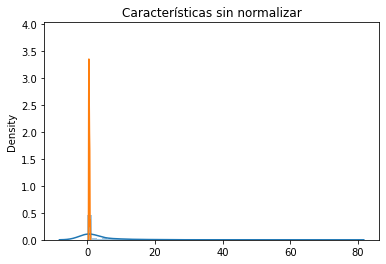

In [ ]:
sns.distplot(X_train[:, 0])
sns.distplot(X_train[:, 4])
plt.title('Características sin normalizar')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


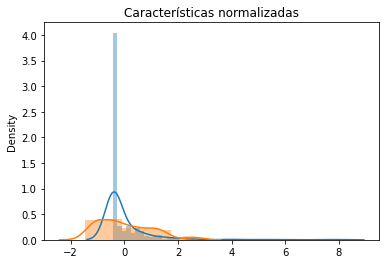

In [ ]:
sns.distplot(X_train_norm[:, 0])
sns.distplot(X_train_norm[:, 4])
plt.title('Características normalizadas')
plt.show()

**Paso 2: Construcción del modelo**

Para construir el modelo primero debemos definir la arquitectura deseada, es decir, el conjunto de capas que forma la red neuronal.
Una vez definida la arquitectura se debe especificar la función de coste a emplear, el optimizador para la actualización de los pesos y las métricas para monitorizar el proceso de entrenamiento. Para esto emplearemos el método "compile()" que hace uso de los parámetros:



*   *optimizer*: Optimizador que define cómo se actualizan los pesos.
*   *loss*: Función de coste a optimizar durante el entrenamiento.
*   *metrics*: Métricas que se computan al final de cada iteración para monitorizar el proeso de entrenamiento. Se computan tanto sobre el conjunto de entrenamiento como, en su caso, el de validación.

En primer lugar vamos a construir una arquitectura sencilla formada por la capa de entrada, una capa oculta con 20 nueronas y la capa de salida. Como función de coste emplearemos el error cuadrático medio.


Evaluación de un problema de regresión

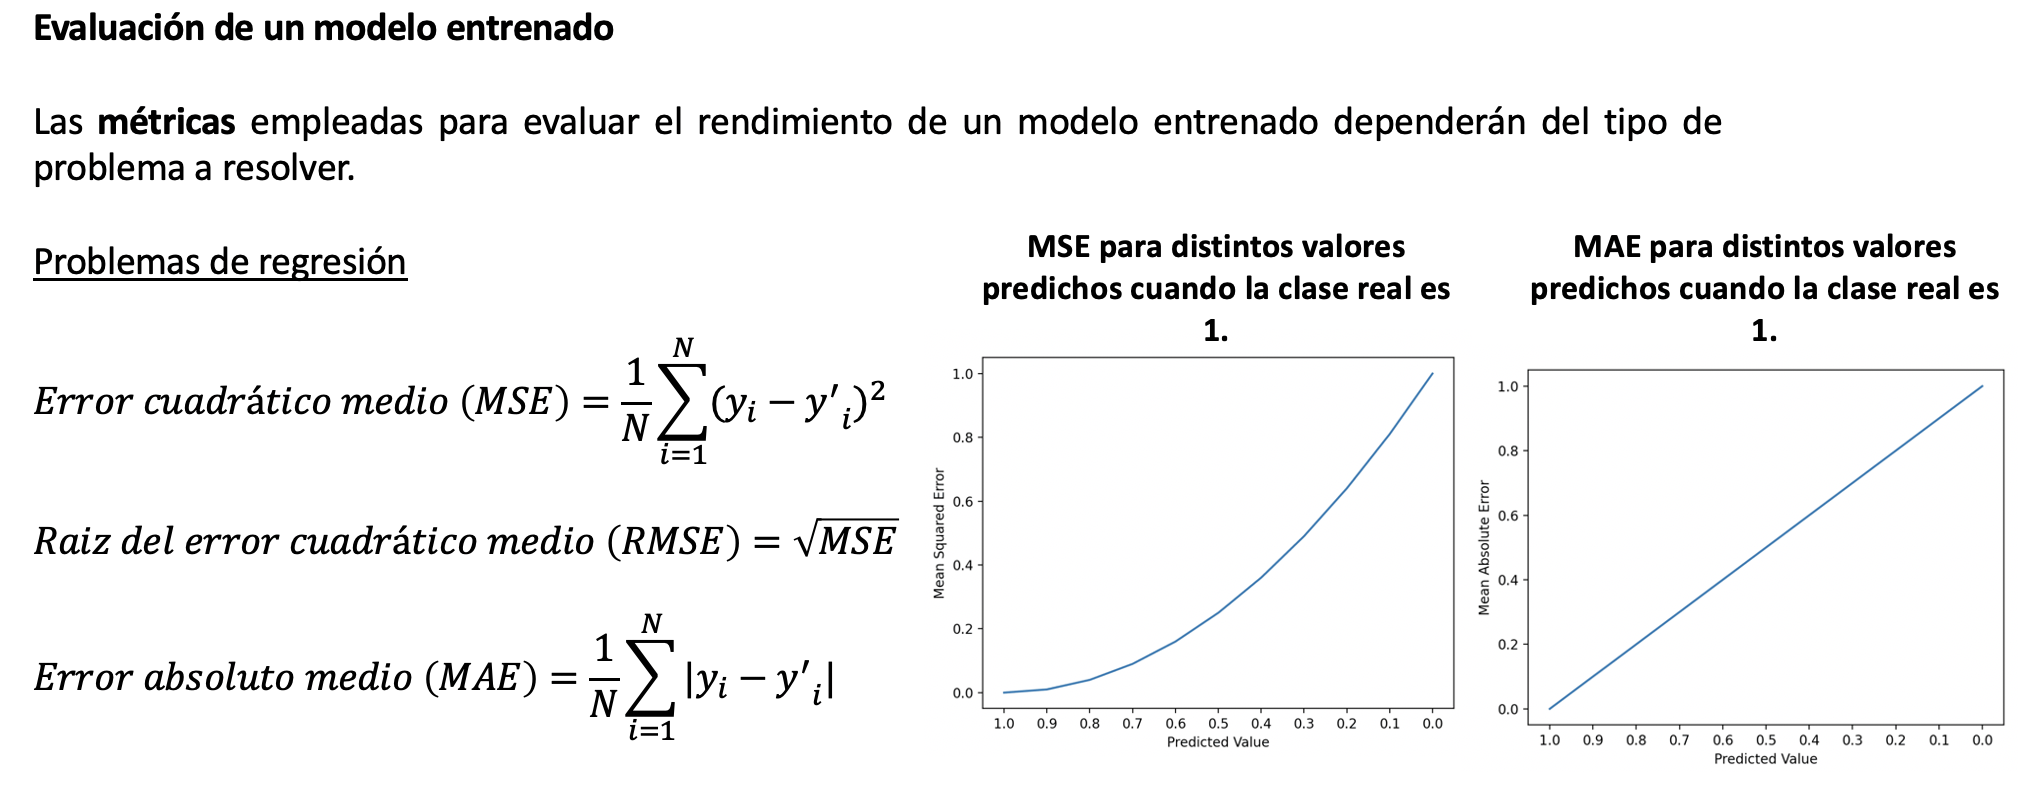

In [ ]:
# Creamos un método que define la arquitectura del modelo
def create_model_regression(n_features):
    model = keras.Sequential()
    model.add(Dense(20, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1)) #Por defecto se emplea función de activación lineal (None)
    return model

In [ ]:
# Definimos la arquitectura del modelo
model_regression = create_model_regression(X_train.shape[1])

# Compilamos
model_regression.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
model_regression.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


**Paso 3: Entrenamiento del modelo**

Una vez definido el modelo hay que entrenarlo, para ello se hade uso del método "fit()" y definiremos el conjunto de datos de entrenamiento, validación, el número de épocas y el tamaño de batch.

In [ ]:
history_reg = model_regression.fit(X_train_norm, y_train, 
                                  epochs=200, batch_size=64,
                                  validation_data=(X_val_norm, y_val))

Epoch 1/200
6/6 [==============================] - 1s 34ms/step - loss: 614.6665 - mae: 22.8142 - mse: 614.6665 - val_loss: 604.5580 - val_mae: 22.8255 - val_mse: 604.5580
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - loss: 608.7663 - mae: 22.7015 - mse: 608.7663 - val_loss: 598.8062 - val_mae: 22.7182 - val_mse: 598.8062
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 603.4811 - mae: 22.5973 - mse: 603.4811 - val_loss: 593.5283 - val_mae: 22.6170 - val_mse: 593.5283
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 598.4724 - mae: 22.4961 - mse: 598.4724 - val_loss: 588.3142 - val_mae: 22.5167 - val_mse: 588.3142
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 593.3882 - mae: 22.3943 - mse: 593.3882 - val_loss: 583.1534 - val_mae: 22.4181 - val_mse: 583.1534
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 588.4990 - mae: 22.2955 - mse: 588.4990 - val_loss: 578.2715 - val_mae: 2

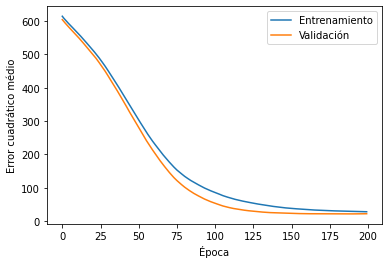

In [ ]:
# Visualizamos el error cuadrático medio obtenido durante el proceso de entrenamiento tanto en entrenamiento como en validación
def plot_history():
    plt.plot(history_reg.history['mse'], label="Entrenamiento")
    plt.plot(history_reg.history['val_mse'], label="Validación")
    plt.ylabel('Error cuadrático médio')
    plt.xlabel('Época')
    plt.legend(loc="upper right")

plot_history()

De la gráfica anterior podemos ver que no se ha producido sobreajuste en el entrenamiento. Representado por la similitud en los valores entre lo obtenido en el conjunto de datos de entrenamiento y el de validación.

**Paso 4: Evaluación del modelo**

Finalmente, hay que evaluar el modelo sobre un nuevo conjunto de datos (datos de test) para comprobar la robustez y capacidad de generalización (reproducibilidad) del modelo que hemos desarrollado. Para ello haremos uso del método "evaluate()", este, dada la entrada y salida esperada extrae las métricas.

Si lo que queremos es únicamente hacer inferencia sobre un nuevo registro emplearemos el método "predict()"

In [ ]:
# Finalmente, evaluamos como se comporta el modelo en el conjunto de datos de test
_, mae, mse = model_regression.evaluate(X_test_norm, y_test)
rmse = np.sqrt(mse)
print('Error cuadrático medio en test: ', mse)
print('Raiz del error cuadrático medio en test: ', rmse)

4/4 [==============================] - 0s 3ms/step - loss: 33.1142 - mae: 4.5507 - mse: 33.1142
Error cuadrático medio en test:  33.11424255371094
Raiz del error cuadrático medio en test:  5.754497593509875


Podemos ver como nos encontramos si nos comparamos con el resto de participantes del reto:

https://www.kaggle.com/c/boston-housing/leaderboard

**Clasificación**

**Paso 1: Preparación de los datos**

Como hemos comentado anteriormente, vamos a afrontar el mismo problema pero, en este caso, resolviendo un problema de clasificación.

Para ello, dividiremos la base de datos en 3 grupos: casos precio ALTO, MEDIO y BAJO.

Para diferenciar estos grupos vamos a ordenar los precios y tomar el mismo numero de registros en cada grupo para evitar desbalanceo entre clases

In [ ]:
indices_sorted = np.argsort(y_train)

print('Rango precio bajo: ', y_train[indices_sorted[0]], ' - ', y_train[indices_sorted[int(np.round(len(indices_sorted)/3)) - 1]])
print('Rango precio medio: ', y_train[indices_sorted[int(np.round(len(indices_sorted)/3))]], ' - ', y_train[indices_sorted[int(2*np.round(len(indices_sorted)/3)) - 1]])
print('Rango precio alto: ', y_train[indices_sorted[int(2*np.round(len(indices_sorted)/3))]], ' - ', y_train[indices_sorted[-1]])

Rango precio bajo:  5.0  -  18.4
Rango precio medio:  18.4  -  23.1
Rango precio alto:  23.2  -  50.0


Si cogemos exáctemente el mismo número de registros en cada clase vemos que tendríamos casos con mismo precio en dos clases diferentes. Para evitar esto vamos a definir los siguientes rangos:

*   Precio bajo: <18.7
*   Precio medio: >=18.7 y <23.6
*   Precio alto: >=23.6

In [ ]:
indices_bajo = np.where(y_train < 18.7)[0]
indices_medio = np.where((y_train >= 18.7) & (y_train < 23.6))[0]
indices_alto = np.where(y_train >= 23.6)[0]

print('Registros bajo: ', len(indices_bajo))
print('Registros medio: ', len(indices_medio))
print('Registros alto: ', len(indices_alto))

Registros bajo:  113
Registros medio:  109
Registros alto:  101


In [ ]:
# Creamos variable respuesta
y_train_labels = np.zeros(shape=(y_train.shape[0], 1))

y_train_labels[indices_bajo, 0] = 0
y_train_labels[indices_medio, 0] = 1
y_train_labels[indices_alto, 0] = 2

print('Tamaño variable salida: ', y_train_labels.shape)

Tamaño variable salida:  (323, 1)


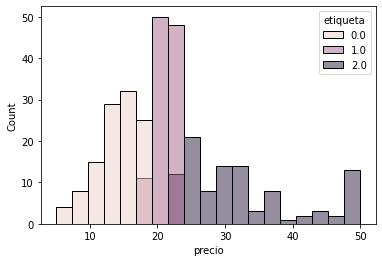

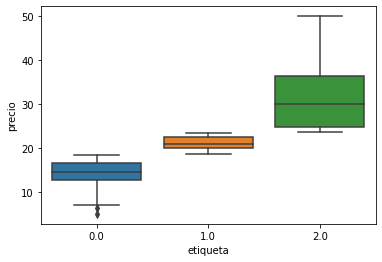

In [ ]:
# Analizamos la distribución de la variable respuesta diferenciando por clase

data = {"precio": y_train, "etiqueta": y_train_labels[:,0]}
df = pd.DataFrame(data=data)

sns.histplot(data=df, x="precio", hue="etiqueta")
plt.figure()
sns.boxplot(data=df, x="etiqueta", y="precio")

Empleamos los mismos umbrales para definir la variable salida de los conjuntos de datos de validación y test

In [ ]:
# Identificamos los índices de los registros para cada grupo
indices_bajo_val = np.where(y_val < 18.7)[0]
indices_medio_val = np.where((y_val >= 18.7) & (y_val < 23.6))[0]
indices_alto_val = np.where(y_val >= 23.6)[0]
print('Registros precios bajos (validación): ', len(indices_bajo_val))
print('Registros precios medios (validación): ', len(indices_medio_val))
print('Registros precios altos (validación): ', len(indices_alto_val))

indices_bajo_test = np.where(y_test < 18.7)[0]
indices_medio_test = np.where((y_test >= 18.7) & (y_test < 23.6))[0]
indices_alto_test = np.where(y_test >= 23.6)[0]
print('Registros precios bajos (test): ', len(indices_bajo_test))
print('Registros precios medios (test): ', len(indices_medio_test))
print('Registros precios altos (test): ', len(indices_alto_test))

# Creamos variable respuesta
y_val_labels = np.zeros(shape=(y_val.shape[0], 1))
y_val_labels[indices_bajo_val, 0] = 0
y_val_labels[indices_medio_val, 0] = 1
y_val_labels[indices_alto_val, 0] = 2

y_test_labels = np.zeros(shape=(y_test.shape[0], 1))
y_test_labels[indices_bajo_test, 0] = 0
y_test_labels[indices_medio_test, 0] = 1
y_test_labels[indices_alto_test, 0] = 2

Registros precios bajos (validación):  25
Registros precios medios (validación):  25
Registros precios altos (validación):  31
Registros precios bajos (test):  26
Registros precios medios (test):  36
Registros precios altos (test):  40


La variable respuesta tiene valores 0, 1, 2 para las clases BAJO, MEDIO, ALTO, respectivamente. Previo a emplear esta variable en la red neuronal vamos a convertirla a codificación OneHot, donde:


*   0 -> [1, 0, 0]
*   1 -> [0, 1, 0]
*   2 -> [0, 0, 1]



In [ ]:
onehot_enc = OneHotEncoder()
y_train_onehot = onehot_enc.fit_transform(y_train_labels).toarray()
y_val_onehot = onehot_enc.fit_transform(y_val_labels).toarray()
y_test_onehot = onehot_enc.fit_transform(y_test_labels).toarray()

print('Valor antes de la codificación: ', y_train_labels[0])
print('Valor después de la codificación: ', y_train_onehot[0])

Valor antes de la codificación:  [1.]
Valor después de la codificación:  [0. 1. 0.]


**Paso 2: Construcción del modelo**

En este caso el modelo que debemos construir debe diseñarse para la resolución de un problema de clasificación.
En cuanto a la arquitectura, lo que marca la diferencia entre ambos problemas (regresión y clasificación) es la función de activación de la capa de salida, donde, en lugar de emplear una función de activación lineal, emplearemos una **función de activación Softmax** al tratarse de un problema multiclase.

Otra diferencicia la marca la **función de coste** a emplear, mientras que para resolver problemas de regresión se suele emplear el error cuadrárico medio, para resolver problemas de clasificación se emplea la **entropía cruzada**.

Finalmente, las métricas a emplear serán las propias de un problema de clasificación. Concretamente, emplearemos la **precisión**.

Así, implementaremos la misma arquitectura con estas diferencias.

In [ ]:
# Creamos un método que define la arquitectura del modelo
def create_model_classification(n_features):
    model = keras.Sequential()
    model.add(Dense(20, activation='relu', input_shape=(n_features,)))
    model.add(Dense(3, activation='softmax')) # El tamaño de la salida ha cambiado a 3 clases
    return model

In [ ]:
# Definimos la arquitectura del modelo
model_classification = create_model_classification(X_train.shape[1])

# Compilamos
model_classification.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_classification.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                280       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 63        
Total params: 343
Trainable params: 343
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamos
history_class = model_classification.fit(X_train_norm, y_train_onehot, 
                                         epochs=100, batch_size=64,
                                         validation_data=(X_val_norm, y_val_onehot))

Epoch 1/100
6/6 [==============================] - 1s 29ms/step - loss: 1.3164 - accuracy: 0.2415 - val_loss: 1.2368 - val_accuracy: 0.2716
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 1.2256 - accuracy: 0.3251 - val_loss: 1.1778 - val_accuracy: 0.3210
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1633 - accuracy: 0.3622 - val_loss: 1.1310 - val_accuracy: 0.3333
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1102 - accuracy: 0.3777 - val_loss: 1.0919 - val_accuracy: 0.3704
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0653 - accuracy: 0.4087 - val_loss: 1.0596 - val_accuracy: 0.3827
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 1.0310 - accuracy: 0.4241 - val_loss: 1.0321 - val_accuracy: 0.3951
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 1.0010 - accuracy: 0.4458 - val_loss: 1.0080 - val_accuracy: 0.4568
Epoch 8/100
6/6 [=========

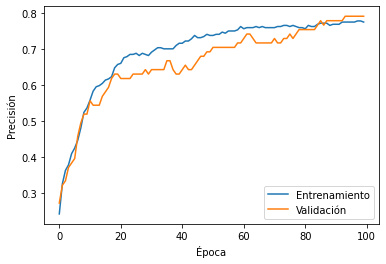

In [ ]:
def plot_history_classification():
    plt.plot(history_class.history['accuracy'], label="Entrenamiento")
    plt.plot(history_class.history['val_accuracy'], label="Validación")
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend(loc="lower right")

plot_history_classification()

**Paso 4: Evaluación del modelo**

In [ ]:
# Finalmente, evaluamos como se comporta el modelo en el conjunto de datos de test
_, acc = model_classification.evaluate(X_test_norm, y_test_onehot, verbose=0)
print('Precisión en test: ', acc)


Precisión en test:  0.7058823704719543


Con el método "evaluate()" podemos generar únicamente las métricas que definimos en su momento al compilar el modelo. 

Por lo que vamos a emplear el método predict() para realizar la predicción. A continuaión generaremos las etiquetas correspondientes y calcularemos las diferentes métricas.

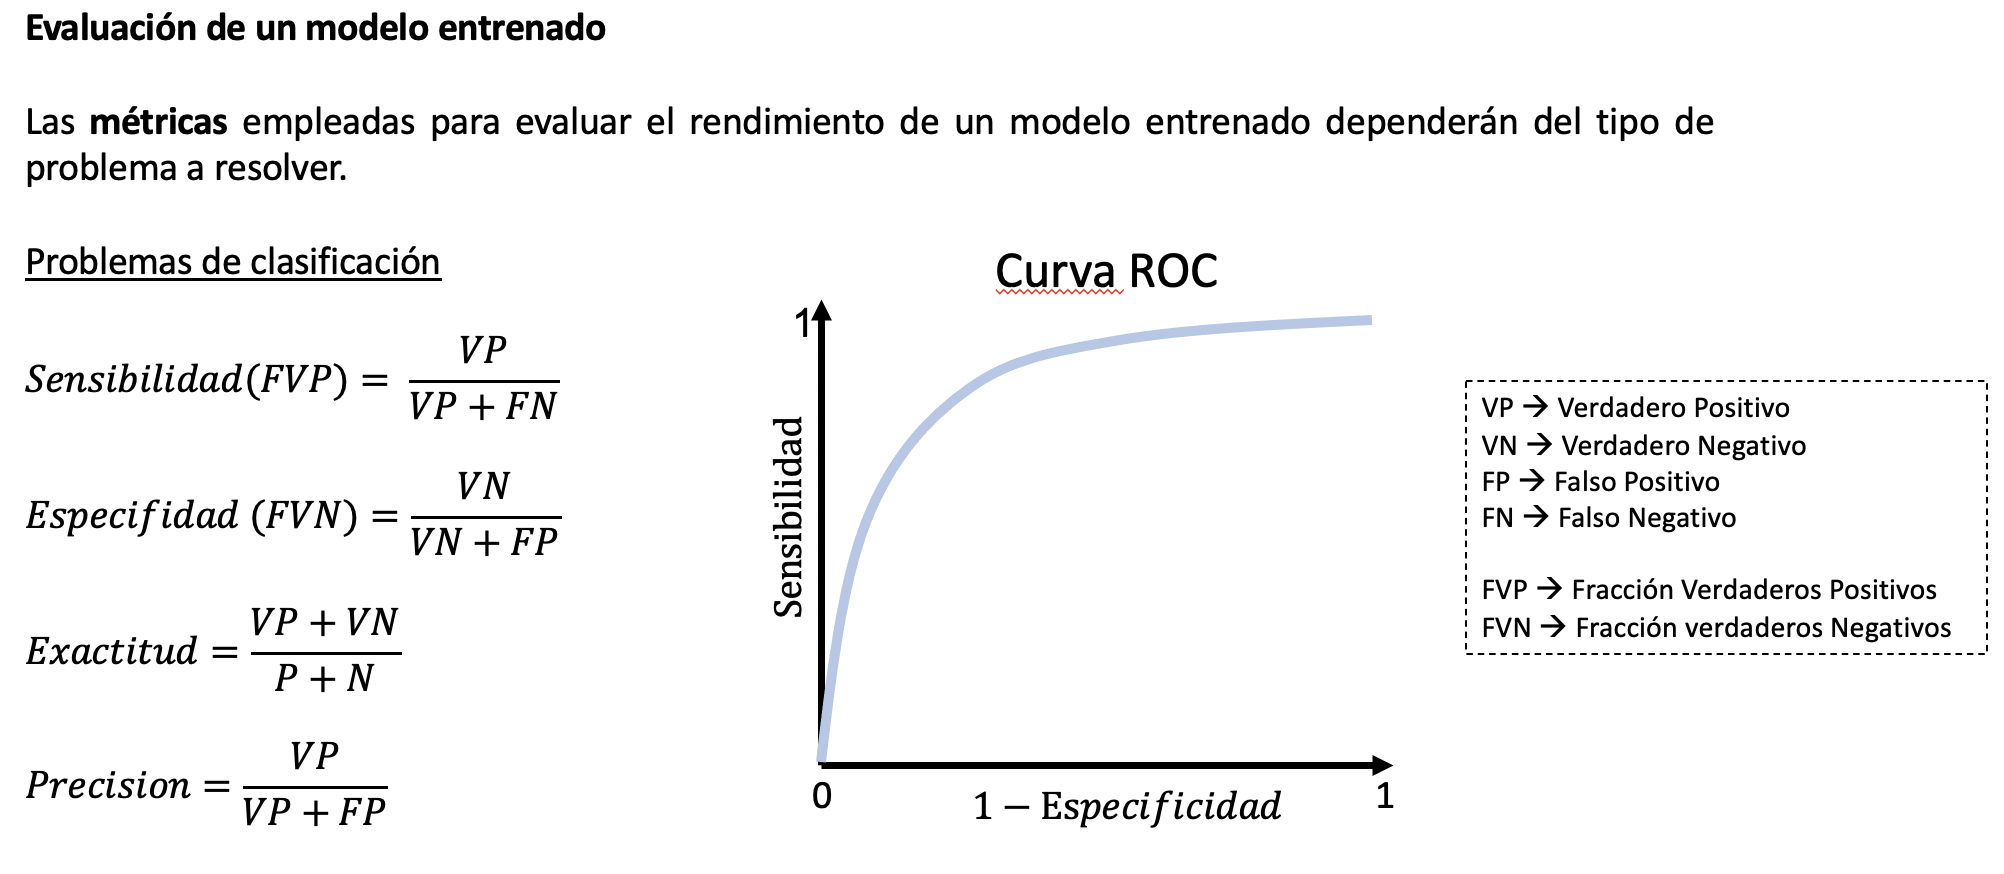

In [ ]:
# Realizamos la predicción del conjunto de test
predictions = model_classification.predict(X_test_norm)
print('Predicción primer registro: ', predictions[0])

Predicción primer registro:  [9.9792933e-01 1.3711220e-03 6.9951802e-04]


In [ ]:
# De la predicción obtenemos la probabilidad de cada clase, para obtener la etiqueta
# correspondiente a cada registro nos quedaremos con la clase que ofrece mayor probabilidad.
predictions_labels = np.argmax(predictions, axis=1)
print('Etiqueta predicción primer registro: ', predictions_labels[0])

Etiqueta predicción primer registro:  0


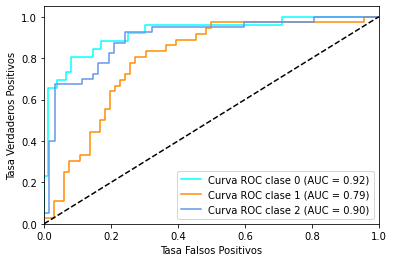

In [ ]:
# Visualización del área bajo la curva ROC
# Dado que es un problema multi-clase se extrae una curva por clase (1 vs el resto)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='Curva ROC clase {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test_labels, predictions_labels)  
print(cm)

[[21  5  0]
 [ 7 24  5]
 [ 2 11 27]]


Text(33.0, 0.5, 'Clase real')

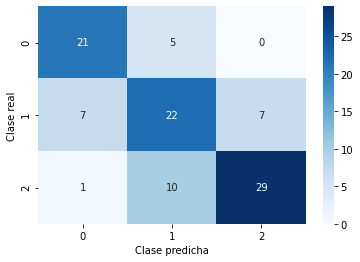

In [ ]:
# Visualizamos la matriz de confusión

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Clase predicha')
plt.ylabel('Clase real')

Text(33.0, 0.5, 'Clase real')

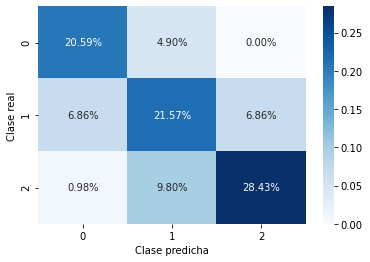

In [ ]:
# Podemos generarlo con los porcentajes de cada clase

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
plt.xlabel('Clase predicha')
plt.ylabel('Clase real')

NOTA: LOS SIGUIENTES NÚMEROS PUEDEN VARIAR ENTRE EJECUCIONES

Observando la matriz de confusión podemos ver que la clase en la que menor error se produce en la predicción es en la clase 0, de los 26 registros que hay de esta clase en el conjunto de datos de test, únicamente 5 están erróneamente clasificadores como clase 1. 
Por contra, la mayor cantidad de errores se produce en la clase 1, donde 14 de los 36 registros se han clasificado erróneamente, 7 se han clasificado como pertenecientes a la clase 0 y otros 7 como clase 2.

Para evaluar las métricas en problemas multi-clase, las métricas se pueden extraer a dos/tres niveles diferentes.


*   **Micro**: Se considera el valor global de VP, FP, VN y FN sin considerar cada clase individualmente. En nuestro ejemplo:


> VP: 21 + 22 + 29 = 72

> FP: (7+1) + (5+10) + (0+7) = 30

> FN: (5+0) + (7+7) + (1+10) = 30

En el nivel micro se obtiene que Exactitud = Recall = F1 Score = Precisión

*   **Macro**: Se calculan las métricas para cada clase individualmente y se calcula la media aritmética de cada métrica.

*   **Ponderado**: Es similar a la anterior, pero en este caso, se pondera la media. El peso que se le asigna a cada clase se corresponde el número total de muestras de esa clase.

Todas estas métricas se pueden calcular haciendo uso de la libería scikit-learn (sklearn):

 

In [ ]:
print('Precisión: {:.2f}\n'.format(accuracy_score(y_test_labels, predictions_labels)))

print('Micro Exactitud: {:.2f}'.format(precision_score(y_test_labels, predictions_labels, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_labels, predictions_labels, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_labels, predictions_labels, average='micro')))

print('Macro Exactitud: {:.2f}'.format(precision_score(y_test_labels, predictions_labels, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_labels, predictions_labels, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_labels, predictions_labels, average='macro')))

print('Weighted Exactitud: {:.2f}'.format(precision_score(y_test_labels, predictions_labels, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_labels, predictions_labels, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_labels, predictions_labels, average='weighted')))

print('\nInforme clasificación:\n')
print(classification_report(y_test_labels, predictions_labels, target_names=['BAJO', 'MEDIO', 'ALTO']))


Precisión: 0.71

Micro Exactitud: 0.71
Micro Recall: 0.71
Micro F1-score: 0.71

Macro Exactitud: 0.71
Macro Recall: 0.71
Macro F1-score: 0.71

Weighted Exactitud: 0.71
Weighted Recall: 0.71
Weighted F1-score: 0.71

Informe clasificación:

              precision    recall  f1-score   support

        BAJO       0.72      0.81      0.76        26
       MEDIO       0.59      0.61      0.60        36
        ALTO       0.81      0.72      0.76        40

    accuracy                           0.71       102
   macro avg       0.71      0.71      0.71       102
weighted avg       0.71      0.71      0.71       102



**Paso 5: Guardado del modelo e inferencia**

Para poder emplear el modelo en producción es necesario guardar el mismo para no tener que ajustarlo cada que queramos emplearlo en producción.

In [ ]:
# Guardamos del modelo entrenado
model_classification.save('./my_model.h5')

In [ ]:
# Cargamos el modelo entrenado
new_model = keras.models.load_model('./my_model.h5')
X_pred = X_test[0,:]

# Normalizamos el registro con la media y std empleada en el entrenamiento
media = np.load('./mean.npy')
std = np.load('./std.npy')
X_pred = (X_pred - media) / std

# Ajustamos la entrada para realizar la predicción a (n_casos, n_características)
# 1 porque queremos realizar la predicción de un único caso.
X_pred = np.reshape(X_pred,(1, len(X_pred)))

# Realizamos predicción
pred = new_model.predict(X_pred)
print('Predicción del modelo: ', pred)
# Extraemos la etiqueta correspondiente
pred_label = np.argmax(pred)
print('Clase predicción: ', pred_label)

Predicción del modelo:  [[9.9792933e-01 1.3711220e-03 6.9951767e-04]]
Clase predicción:  0


# Complejidad arquitectura

En esta sección vamos a tratar de generar una arquitectura más compleja para ver si esta nos ofrece mejores resultados.

Para aumentar la complejidad de una arquitectura podemos tanto crear redes más profundas, es decir, con más capas ocultas, o incluir más neuronas en estas capas ocultas.

**Prueba 1: Incrementamos el número de neuronas en la capa oculta**

In [ ]:
def create_model_classification_nodes(n_features, n_hidden_nodes):
    model = keras.Sequential()
    model.add(Dense(n_hidden_nodes, activation='relu', input_shape=(n_features,)))
    model.add(Dense(3, activation='softmax')) # El tamaño de la salida ha cambiado a 3 clases
    return model

In [ ]:
# Probamos con 50, 100, 200 y 500 neuronas

model_50 = create_model_classification_nodes(X_train.shape[1], 50)
model_50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_100 = create_model_classification_nodes(X_train.shape[1], 100)
model_100.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_200 = create_model_classification_nodes(X_train.shape[1], 200)
model_200.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_500 = create_model_classification_nodes(X_train.shape[1], 500)
model_500.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenamos los modelos (verbose=0 para que no salgan los logs del entrenamiento)
history_50 = model_50.fit(X_train_norm, y_train_onehot, 
                          epochs=100, batch_size=64,
                          validation_data=(X_val_norm, y_val_onehot),
                          verbose=0)

history_100 = model_100.fit(X_train_norm, y_train_onehot, 
                            epochs=100, batch_size=64,
                            validation_data=(X_val_norm, y_val_onehot),
                            verbose=0)

history_200 = model_200.fit(X_train_norm, y_train_onehot, 
                            epochs=100, batch_size=64,
                            validation_data=(X_val_norm, y_val_onehot),
                            verbose=0)

history_500 = model_500.fit(X_train_norm, y_train_onehot, 
                            epochs=100, batch_size=64,
                            validation_data=(X_val_norm, y_val_onehot),
                            verbose=0)

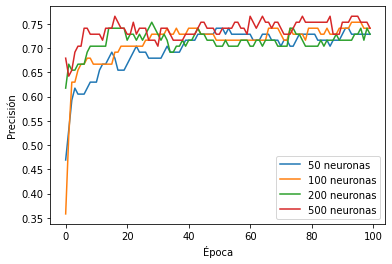

In [ ]:
# Comparamos métricas validación
#plt.plot(history_class.history['val_accuracy'], label="20 neuronas")
plt.plot(history_50.history['val_accuracy'], label="50 neuronas")
plt.plot(history_100.history['val_accuracy'], label="100 neuronas")
plt.plot(history_200.history['val_accuracy'], label="200 neuronas")
plt.plot(history_500.history['val_accuracy'], label="500 neuronas")
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(loc="lower right")

(0.7, 0.9)

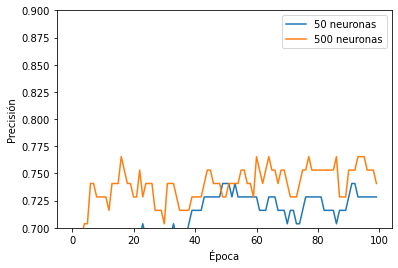

In [ ]:
# Comparamos métricas validación centrándonos en el rango 0.7 - 0.9

#plt.plot(history_class.history['val_accuracy'], label="20 neuronas")
plt.plot(history_50.history['val_accuracy'], label="50 neuronas")
#plt.plot(history_100.history['val_accuracy'], label="100 neuronas")
#plt.plot(history_200.history['val_accuracy'], label="200 neuronas")
plt.plot(history_500.history['val_accuracy'], label="500 neuronas")
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(loc="upper right")
plt.ylim([0.7, 0.9])

A priori se obtienen resultados similares, si que se observa mayor inestabilidad en el entrenamiento cuando aumentamos el número de neuronas. Vamos a observar que ocurre en test.

In [ ]:
_, acc_50 = model_50.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_100 = model_100.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_200 = model_200.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_500 = model_500.evaluate(X_test_norm, y_test_onehot, verbose=0)
#print('Precisión 20 neuronas: ', acc)
print('Precisión 50 neuronas: ', acc_50)
print('Precisión 100 neuronas: ', acc_100)
print('Precisión 200 neuronas: ', acc_200)
print('Precisión 500 neuronas: ', acc_500)

Precisión 50 neuronas:  0.7745097875595093
Precisión 100 neuronas:  0.8235294222831726
Precisión 200 neuronas:  0.8039215803146362
Precisión 500 neuronas:  0.813725471496582


En el set de test podemos ver como conforme se aumenta el número de neuronas mejora el rendimiento del modelo hasta un valor (100) a partir del cual el rendimiento disminuye.

**Prueba 2: Incrementamos el número de capas ocultas**

In [ ]:
# Método para definir número de capas ocultas deseadas y número de neuronas en cada capa
def create_model_classification_hidden(n_features, n_hidden_layers, n_nodes_hidden_layers):
    model = keras.Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    for i in range(n_hidden_layers):
      model.add(Dense(n_nodes_hidden_layers[i], activation='relu'))

    model.add(Dense(3, activation='softmax')) # El tamaño de la salida ha cambiado a 3 clases
    return model

In [ ]:
# Probamos con 2, 4, 10 y 20 capas

model_2_layers = create_model_classification_hidden(X_train.shape[1], 2, [20, 50])
model_2_layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4_layers = create_model_classification_hidden(X_train.shape[1], 4, [20, 50, 20, 10])
model_4_layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_10_layers = create_model_classification_hidden(X_train.shape[1], 10, [20, 50, 20, 10, 20, 50, 10, 30, 40, 20])
model_10_layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_20_layers = create_model_classification_hidden(X_train.shape[1], 20, [20, 50, 20, 10, 20, 50, 10, 30, 40, 20, 20, 50, 20, 10, 20, 50, 10, 30, 40, 20])
model_20_layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenamos los modelos
history_2l = model_2_layers.fit(X_train_norm, y_train_onehot, 
                                epochs=200, batch_size=64,
                                validation_data=(X_val_norm, y_val_onehot),
                                verbose=0)

history_4l = model_4_layers.fit(X_train_norm, y_train_onehot, 
                                epochs=200, batch_size=64,
                                validation_data=(X_val_norm, y_val_onehot),
                                verbose=0)

history_10l = model_10_layers.fit(X_train_norm, y_train_onehot, 
                                  epochs=200, batch_size=64,
                                  validation_data=(X_val_norm, y_val_onehot),
                                  verbose=0)

history_20l = model_20_layers.fit(X_train_norm, y_train_onehot, 
                                  epochs=200, batch_size=64,
                                  validation_data=(X_val_norm, y_val_onehot),
                                  verbose=0)

(0.7, 0.9)

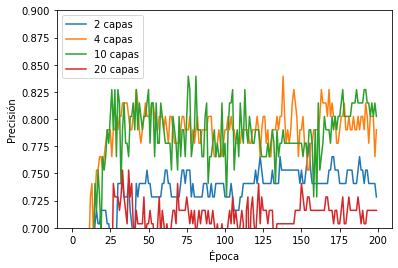

In [ ]:
# Comparamos métricas validación
#plt.plot(history_class.history['val_accuracy'], label="1 capa")
plt.plot(history_2l.history['val_accuracy'], label="2 capas")
plt.plot(history_4l.history['val_accuracy'], label="4 capas")
plt.plot(history_10l.history['val_accuracy'], label="10 capas")
plt.plot(history_20l.history['val_accuracy'], label="20 capas")
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(loc="upper left")
plt.ylim([0.7, 0.9])

Vemos que los mejores resultados se obtienen con 4 capas. Vemos los resultados en test

In [ ]:
_, acc_2l = model_2_layers.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_4l = model_4_layers.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_10l = model_10_layers.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_20l = model_20_layers.evaluate(X_test_norm, y_test_onehot, verbose=0)
#print('Precisión 1 capa: ', acc)
print('Precisión 2 capas: ', acc_2l)
print('Precisión 4 capas: ', acc_4l)
print('Precisión 10 capas: ', acc_10l)
print('Precisión 20 capas: ', acc_20l)

Precisión 2 capas:  0.7941176295280457
Precisión 4 capas:  0.8235294222831726
Precisión 10 capas:  0.7745097875595093
Precisión 20 capas:  0.7549019455909729


Se requiere mayor experimentación para seleccionar la configuración ideal sin embargo, podemos concluir que aumentar mucho la complejidad de la arquitectura no ofrece mejores resultados. Hemos visto que aumentando mucho el número de neuronas (>200 neuronas), se obtiene resultados similares a los obtenidos con 20 neuronas, sin embargo, la carga computacional aumenta. Lo mismo ocurre aumentando el número de capas, vemos como con un número de capas >10 se obtienen peores resultados que empleando, por ejemplo, 2 capas ocultas. 


**En la siguiente sesión veremos qué otros hiperparámetros podemos evaluar para seleccionar la arquitectura óptima.**